# Autoencoder for getting vector embeddings

**Advisor:** Marcos M. Raimundo <br>
**Co-Advisor:** Thalita Veronese <br>
**Student:** João Victor P. B. Avanzini

## Imports

In [1]:
import tensorflow as tf
import os

import neurokit2 as nk


import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Input, Conv1DTranspose, Conv2DTranspose, Reshape
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, Conv1DTranspose, Reshape
from tensorflow.keras.optimizers import Adam

from matplotlib.offsetbox import OffsetImage, AnnotationBbox


sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

2023-12-16 17:51:19.506343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-16 17:51:19.506385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-16 17:51:19.507510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-16 17:51:19.514353: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-16 17:51:20.490475: W tensorflow/compiler/tf2

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:04:00.0, compute capability: 5.2
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:05:00.0, compute capability: 5.2



2023-12-16 17:51:22.657615: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11602 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:04:00.0, compute capability: 5.2
2023-12-16 17:51:22.658223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11601 MB memory:  -> device: 1, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:05:00.0, compute capability: 5.2


## 50 Subjects of single ECG autoencoder

In [2]:
subjects = pd.read_csv('../scripting/ecg_downloader/data/merged_ecg_data.csv')

In [3]:
subjects.shape

(7500000, 1)

In [5]:
subjects_reshaped = subjects.values.reshape((250, 30000, 1))
subjects_reshaped.shape

(250, 30000, 1)

In [6]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2023-12-16 17:51:23.743208: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11602 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:04:00.0, compute capability: 5.2
2023-12-16 17:51:23.743425: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11601 MB memory:  -> device: 1, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:05:00.0, compute capability: 5.2


In [7]:
with strategy.scope():
    encoder = tf.keras.models.Sequential([
        Conv1D(64, 250, activation='relu', padding='same', input_shape=(30000, 1)),
        Dense(32, activation='relu'),
        MaxPooling1D(),
        Conv1D(32, 250, activation='relu', padding='same'),
        Dense(16, activation='relu'),
        MaxPooling1D(),
        Flatten(),
        Dense(8)
    ], name='encoder')

    decoder = tf.keras.models.Sequential([
        Reshape((8, 1)),
        Conv1DTranspose(8, 29993, activation='relu', input_shape=(8, 1)),
        Dense(16, activation='relu'),
        Conv1DTranspose(16, 250, activation='relu', padding='same'),
        Dense(32, activation='relu'),
        Conv1DTranspose(32, 250, activation='relu', padding='same'),
        Dense(64, activation='relu'),
        Conv1DTranspose(1, 250, activation='relu', padding='same'),
    ], name='decoder')

    custom_optimizer = Adam(learning_rate=0.001)
    autoencoder = Sequential([encoder, decoder])
    autoencoder.compile(optimizer=custom_optimizer, loss="mse")

In [8]:
history = autoencoder.fit(subjects_reshaped, subjects_reshaped, batch_size=128, epochs=10, verbose=1)

Epoch 1/10
INFO:tensorflow:Collective all_reduce tensors: 24 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 24 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2023-12-16 17:51:29.514659: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-16 17:51:29.548427: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-16 17:53:39.026138: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f40392accf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-16 17:53:39.026169: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-12-16 17:53:39.026175: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-12-16 17:53:39.032376: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702749219.141678    3160 device_compiler.h:186] Compiled clust

2/2 [==============================] - ETA: 0s - loss: 0.1564  INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2/2 [==============================] - 259s 123s/step - loss: 0.1564
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 0.1700INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:

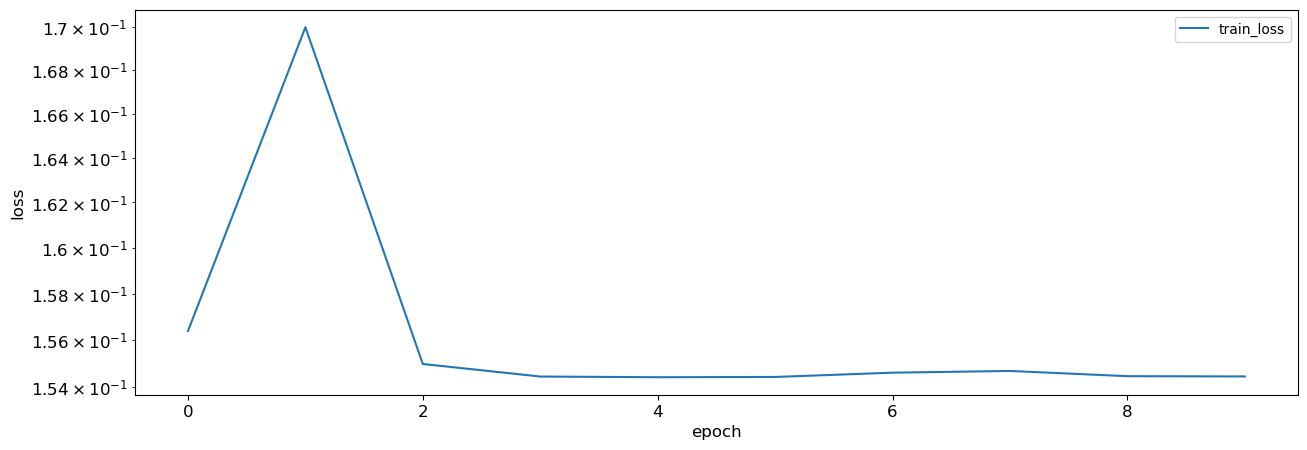

In [9]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

## Inference

In [10]:
subject_60 = pd.read_csv('../scripting/ecg_downloader/data/output_blobs_case_60/all_subject_60_blobs.csv')

In [11]:
subject_60.shape

(150000, 1)

In [12]:
subject_60_reshaped = subject_60.values.reshape((5, 30000, 1))
subject_60_reshaped.shape

(5, 30000, 1)

In [13]:
latent_representations = encoder.predict(subject_60_reshaped)
latent_representations

1/1 [==============================] - 1s 971ms/step


array([[ 69.373184 , -46.125877 , -41.824886 ,  63.947063 ,  74.69708  ,
        -47.933064 , -62.68775  ,  52.03764  ],
       [ 25.636044 , -17.181452 , -15.0649185,  23.378096 ,  28.56777  ,
        -17.155151 , -22.718584 ,  18.673882 ],
       [ 29.483627 , -20.870613 , -19.559595 ,  27.881256 ,  32.58804  ,
        -22.56728  , -27.568958 ,  23.07753  ],
       [  7.795468 ,  -4.955587 ,  -4.493782 ,   7.119462 ,   8.408669 ,
         -4.974313 ,  -6.773659 ,   5.6140985],
       [ 43.18488  , -29.463644 , -26.345884 ,  41.25235  ,  47.581673 ,
        -28.799288 , -40.103916 ,  31.658024 ]], dtype=float32)

In [14]:
reconstructed_ecg = decoder.predict(latent_representations)
reconstructed_ecg_reshaped = reconstructed_ecg.reshape((-1, 1))
print(reconstructed_ecg_reshaped)

1/1 [==============================] - 2s 2s/step
[[0.03576845]
 [0.03585922]
 [0.03565954]
 ...
 [0.03821881]
 [0.03770499]
 [0.03723916]]


Text(0, 0.5, 'Signal Value')

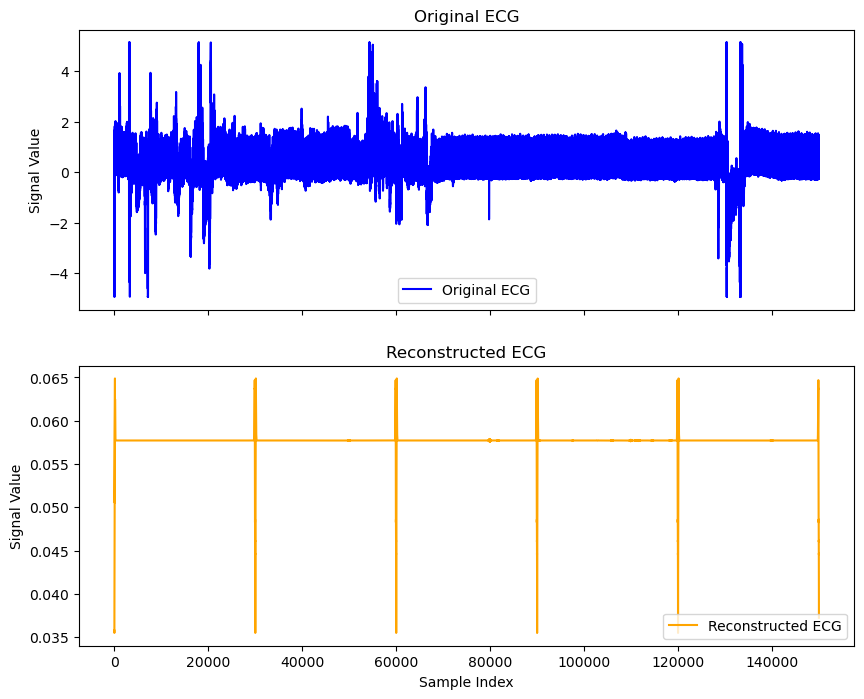

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axs[0].plot(subject_60, label='Original ECG', color='blue')
axs[0].legend()
axs[0].set_title('Original ECG')
axs[0].set_ylabel('Signal Value')

axs[1].plot(reconstructed_ecg_reshaped, label='Reconstructed ECG', color='orange')
axs[1].legend()
axs[1].set_title('Reconstructed ECG')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Signal Value')

In [16]:
mse = np.mean(np.square(subject_60 - reconstructed_ecg_reshaped))
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 0.4231552007310552
